# 1. 데이터 & 라이브러리 준비

In [ ]:
!pip install pwlf
!pip install tensorflow

In [3]:
import csv
import pwlf
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, save_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

tf.get_logger().setLevel('ERROR')

In [4]:
df = pd.read_excel('piecewise_linear_data.xlsx', engine='openpyxl')

cols = list(df.columns)
x_cols = cols[0::2]
y_cols = cols[1::2]

X = pd.concat([df[c] for c in x_cols], ignore_index=True)
Y = pd.concat([df[c] for c in y_cols], ignore_index=True)

X = pd.to_numeric(X, errors='coerce')
Y = pd.to_numeric(Y, errors='coerce')

data = pd.DataFrame({'X': X, 'Y': Y}).dropna().reset_index(drop=True)
data.head()

,X,Y
0,4.451290,0.056797
1,0.508272,-0.002200
2,1.537680,-0.002510
3,4.497240,0.022089
4,5.673710,0.058464


# 2. Piecewise Linear Regression

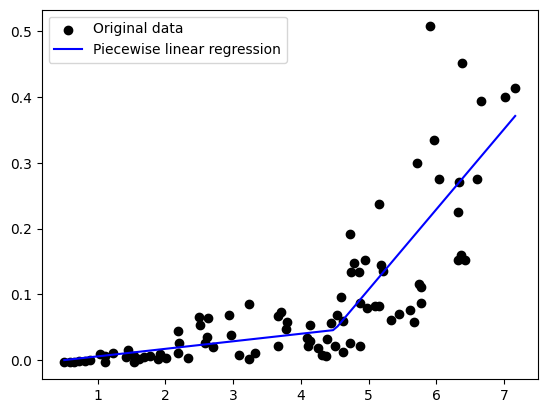

In [5]:
data = np.array(data)
X_o = data[:, 0]
y_o = data[:, 1]

my_pwlf = pwlf.PiecewiseLinFit(X_o, y_o)
breaks = my_pwlf.fit(2)

x_hat = np.linspace(X_o.min(), X_o.max(), 100)
y_hat_pw = my_pwlf.predict(x_hat)

plt.scatter(X_o, y_o, label='Original data', color='black')
plt.plot(x_hat, y_hat_pw, 'b-', label='Piecewise linear regression')
plt.legend()
plt.show()

# 3. Neural Network

데이터 전처리

In [6]:
np.random.shuffle(data)
X_o = data[:, 0]
y_o = data[:, 1]

X_o = X_o.reshape((len(X_o), 1))
y_o = y_o.reshape((len(y_o), 1))

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(X_o)
y = scaler_y.fit_transform(y_o)

모델 정의 함수 구현

In [7]:
def neural_network(n_layer, n_neuron, activation_function='relu'):
    model = Sequential()
    model.add(Input(shape=(1,)))
    model.add(Dense(n_neuron, activation=activation_function))
    for _ in range(n_layer - 1):
        model.add(Dense(n_neuron, activation=activation_function))
    model.add(Dense(1))

    model.summary()
    return model

모델 학습 & 저장 함수 구현

In [8]:
def train_and_save(X, y, model, n_layer, n_neuron):
  model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

  history = model.fit(
      X, y,
      validation_split=0.1,
      batch_size=80,
      epochs=800,
      shuffle=True,
      verbose=0
  )

  model_name = f'model_{n_neuron}_neuron_{n_layer}_hidden_layer.keras'
  model.save(model_name)

그래프 plot 함수 구현

In [9]:
def plot_graph(X, y_hat_pw, model, n_layer, n_neuron):
    X_uniform = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    predictions = model.predict(X_uniform, batch_size=100, verbose=0)
    X_uniform_o = scaler_X.inverse_transform(X_uniform)
    predictions_o = scaler_y.inverse_transform(predictions)

    plt.close('all')
    plt.figure(figsize=(8,5))
    plt.scatter(X_o, y_o, label='Original data', color='black')
    plt.plot(x_hat, y_hat_pw, 'b-', label='Piecewise linear regression')
    plt.plot(X_uniform_o, predictions_o, 'r*', markersize=3, label=f'FFN, {n_neuron} neuron {n_layer} hidden layer')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.tight_layout()
    plt.show()

(1) 1 hidden layer, 2 neuron

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

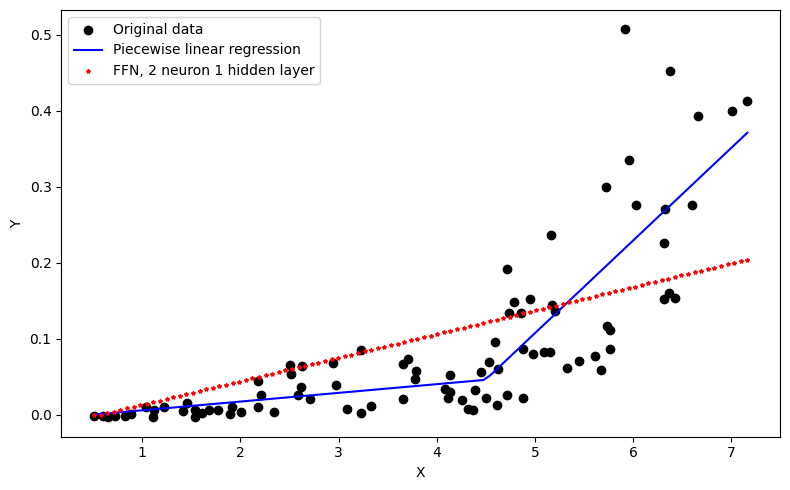

In [10]:
n_layer = 1
n_neuron = 2

model = neural_network(n_layer, n_neuron)
train_and_save(X, y, model, n_layer, n_neuron)
plot_graph(X, y_hat_pw, model, n_layer, n_neuron)

(2) 1 hidden layer, 10 neuron

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

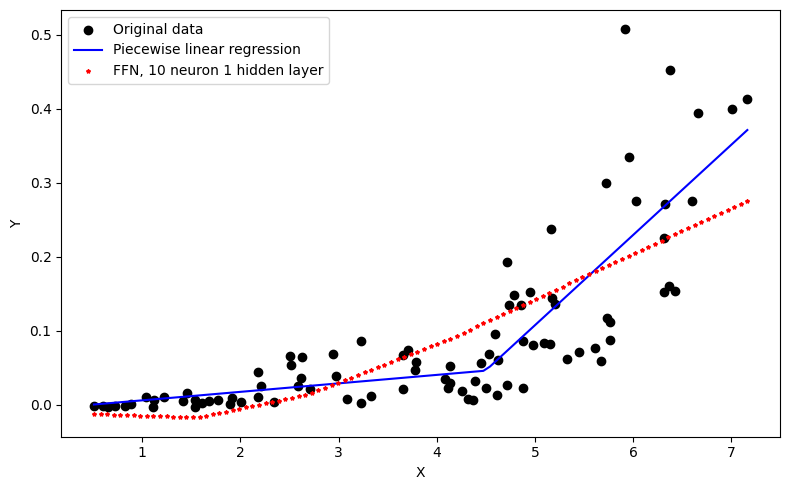

In [11]:
n_layer = 1
n_neuron = 10

model = neural_network(n_layer, n_neuron)
train_and_save(X, y, model, n_layer, n_neuron)
plot_graph(X, y_hat_pw, model, n_layer, n_neuron)

(3) 2 hidden layer, 10 neuron

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

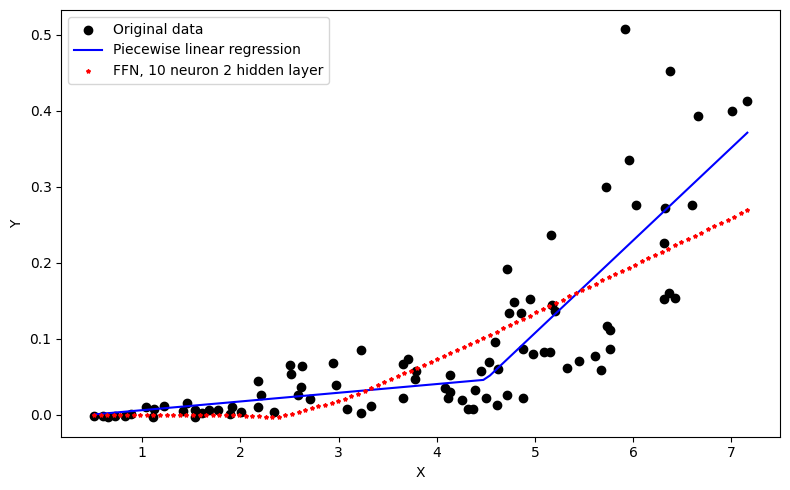

In [12]:
n_layer = 2
n_neuron = 10

model = neural_network(n_layer, n_neuron)
train_and_save(X, y, model, n_layer, n_neuron)
plot_graph(X, y_hat_pw, model, n_layer, n_neuron)

(4) 3 hidden layer, 10 neuron

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

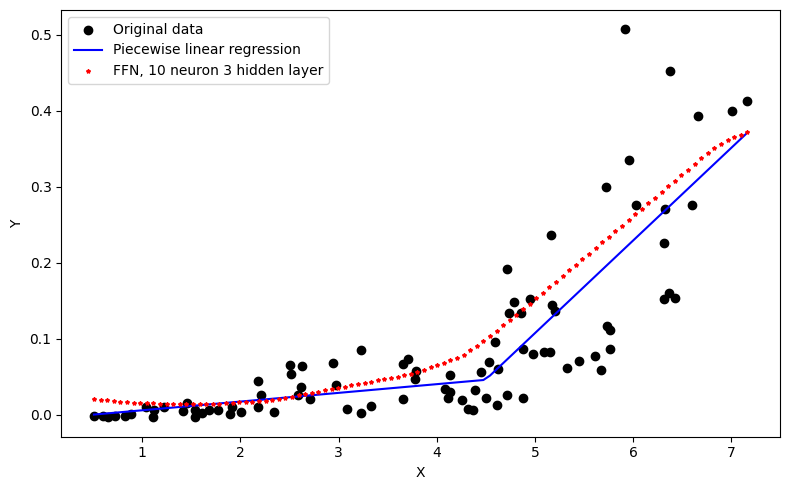

In [13]:
n_layer = 3
n_neuron = 10

model = neural_network(n_layer, n_neuron)
train_and_save(X, y, model, n_layer, n_neuron)
plot_graph(X, y_hat_pw, model, n_layer, n_neuron)

(5) 4 hidden layer, 10 neuron

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

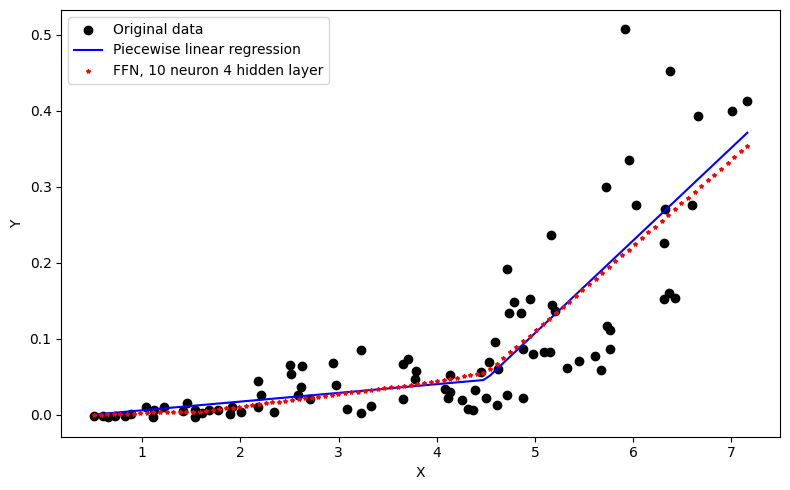

In [14]:
n_layer = 4
n_neuron = 10

model = neural_network(n_layer, n_neuron)
train_and_save(X, y, model, n_layer, n_neuron)
plot_graph(X, y_hat_pw, model, n_layer, n_neuron)

# 4. Evaluate Performance

In [15]:
model_files = sorted(
    [f for f in os.listdir() if f.endswith('.keras') and f.startswith('model_')],
    key=lambda x: (
        int(re.search(r'model_(\d+)_neuron', x).group(1)),
        int(re.search(r'_(\d+)_hidden_layer', x).group(1))
    )
)

results = []

for model_file in model_files:
    pattern = r'model_(\d+)_neuron_(\d+)_hidden_layer\.keras'
    match = re.match(pattern, model_file)

    n_neuron = int(match.group(1))
    n_layer = int(match.group(2))

    model = keras.models.load_model(model_file)
    y_pred = model.predict(X, verbose=0)
    y_pred_o = scaler_y.inverse_transform(y_pred)

    mse = mean_squared_error(y_o, y_pred_o)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_o, y_pred_o)
    r2 = r2_score(y_o, y_pred_o)

    results.append({
        'n_layer': n_layer,
        'n_neuron': n_neuron,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R^2': r2
    })

results_df = pd.DataFrame(results)
results_df

,n_layer,n_neuron,MSE,RMSE,MAE,R^2
0,1,2,0.007022,0.083797,0.059160,0.455538
1,1,10,0.005273,0.072613,0.052881,0.591168
2,2,10,0.005115,0.071519,0.049272,0.603402
3,3,10,0.004778,0.069122,0.049016,0.629542
4,4,10,0.003858,0.062109,0.040420,0.700896


모델 별 평가지표(RMSE, MSE, MAE, R^2) 시각화

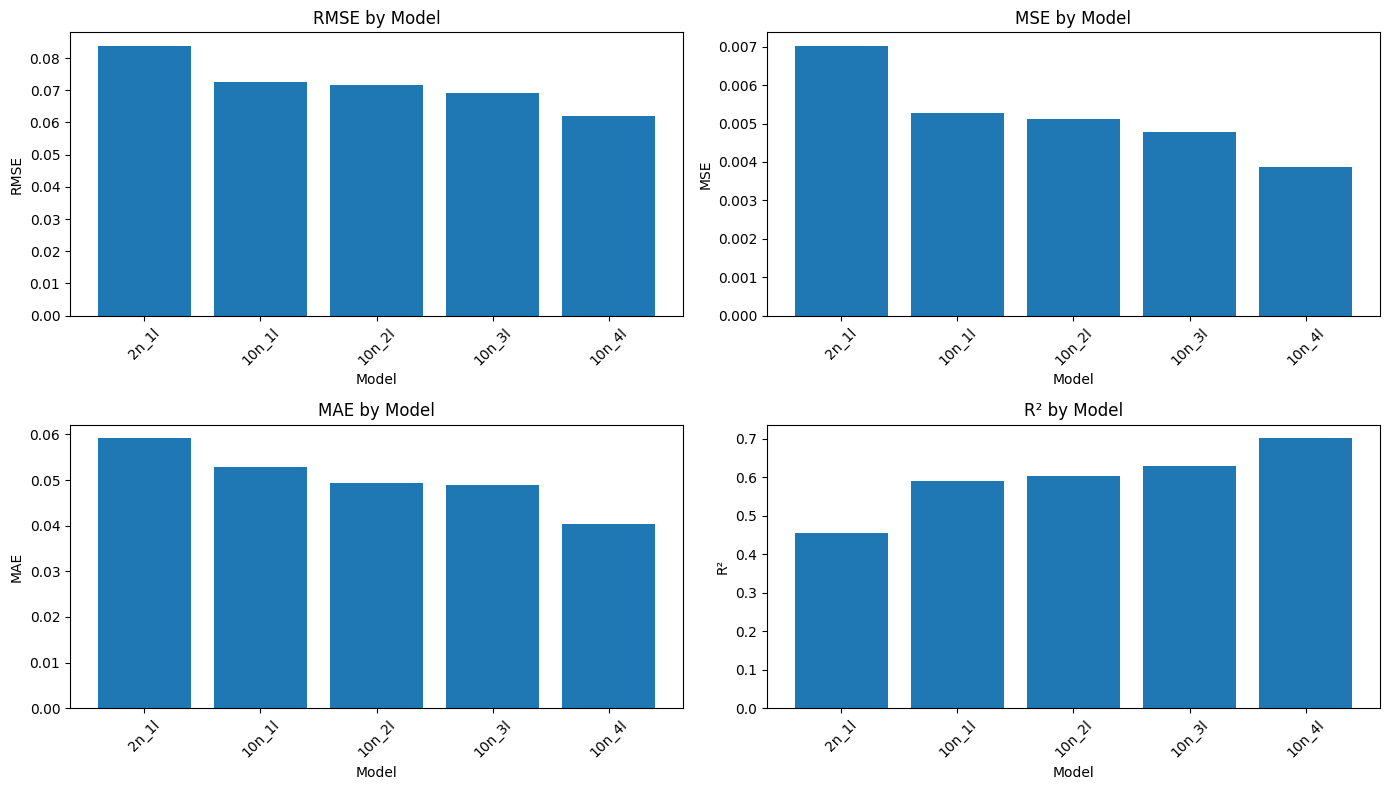

In [19]:
X_o = scaler_X.inverse_transform(X)
y_o = scaler_y.inverse_transform(y)

plt.figure(figsize=(14, 8))

model_labels = [f"{int(row['n_neuron'])}n_{int(row['n_layer'])}l" for _, row in results_df.iterrows()]

# RMSE
plt.subplot(2, 2, 1)
plt.bar(model_labels, results_df['RMSE'])
plt.title('RMSE by Model')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# MSE
plt.subplot(2, 2, 2)
plt.bar(model_labels, results_df['MSE'])
plt.title('MSE by Model')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.xticks(rotation=45)

# MAE
plt.subplot(2, 2, 3)
plt.bar(model_labels, results_df['MAE'])
plt.title('MAE by Model')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.xticks(rotation=45)

# R^2
plt.subplot(2, 2, 4)
plt.bar(model_labels, results_df['R^2'])
plt.title('R² by Model')
plt.xlabel('Model')
plt.ylabel('R²')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

레이어 수에 따른 RMSE 비교

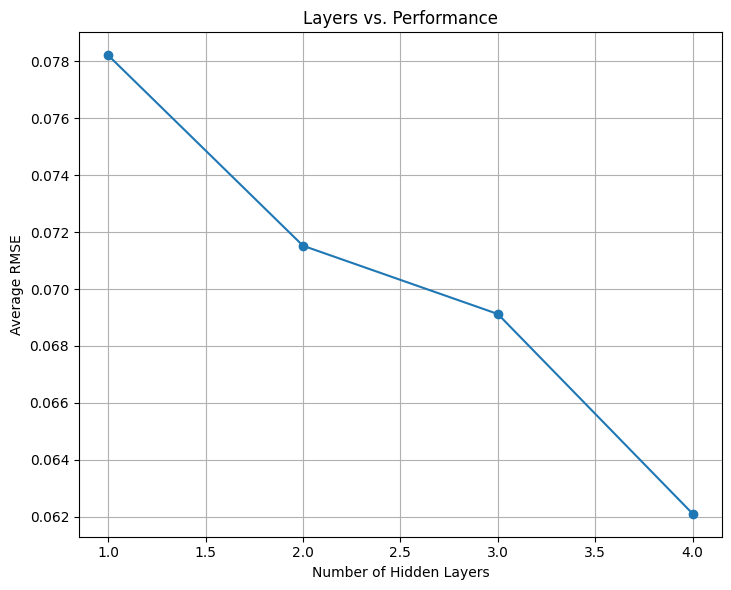

In [20]:
if len(results_df['n_neuron'].unique()) > 1 or len(results_df['n_layer'].unique()) > 1:
    plt.figure(figsize=(14, 6))

    if len(results_df['n_layer'].unique()) > 1:
        plt.subplot(1, 2, 2)
        layer_groups = results_df.groupby('n_layer')['RMSE'].mean().reset_index()
        plt.plot(layer_groups['n_layer'], layer_groups['RMSE'], marker='o')
        plt.xlabel('Number of Hidden Layers')
        plt.ylabel('Average RMSE')
        plt.title('Layers vs. Performance')
        plt.grid(True)

    plt.tight_layout()
    plt.show()